# imports

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

# supress the warnings
import warnings

warnings.filterwarnings("ignore")
# supress ConvergenceWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [2]:
train_df_ = pd.read_csv(
    "/kaggle/input/icr-identify-age-related-conditions/train.csv"
)
test_df_ = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")

# Preprocess

In [3]:
y_train = train_df_["Class"]
train_df = train_df_.drop("Class", axis=1)

ids = test_df_["Id"]
train_df.drop("Id", axis=1, inplace=True)
test_df = test_df_.drop("Id", axis=1)

In [4]:
# do one-hot encoding to EJ column

train_df["EJ"] = train_df["EJ"].apply(lambda x: 1 if x == "A" else 0)
test_df["EJ"] = test_df["EJ"].apply(lambda x: 1 if x == "A" else 0)

In [5]:
# Fill missing values with median if less than 3 values are missing else impute with KNN imputer

col_fill_na_median = []
col_fill_na_knn = []

for col in train_df.columns:
    if train_df[col].isnull().sum() > 2:
        col_fill_na_knn.append(col)
    elif train_df[col].isnull().sum() > 0:
        col_fill_na_median.append(col)
        
for col in test_df.columns:
    if test_df[col].isnull().sum() > 2:
        col_fill_na_knn.append(col)
    elif test_df[col].isnull().sum() > 0:
        col_fill_na_median.append(col)

print("Columns to fill with median: ", col_fill_na_median)
print("Columns to fill with KNN: ", col_fill_na_knn)

Columns to fill with median:  ['CB', 'DU', 'FC', 'FL', 'FS', 'GL']
Columns to fill with KNN:  ['BQ', 'CC', 'EL']


In [6]:
# fill missing values with mdeian

transformers_1 = []
transformers_1.append(
    (
        "median_imputer",
        SimpleImputer(
            strategy="median",
        ),
        col_fill_na_median,
    )
)

# fill missing values with KNN

transformers_1.append(
    (
        "knn_imputer",
        KNNImputer(
            n_neighbors=5,
        ),
        col_fill_na_knn,
    )
)

print(transformers_1)

preprocessor = ColumnTransformer(transformers=transformers_1, remainder="passthrough")

scaler = StandardScaler()


pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("scaler", scaler)])
pipeline

[('median_imputer', SimpleImputer(strategy='median'), ['CB', 'DU', 'FC', 'FL', 'FS', 'GL']), ('knn_imputer', KNNImputer(), ['BQ', 'CC', 'EL'])]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('median_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['CB', 'DU', 'FC', 'FL', 'FS',
                                                   'GL']),
                                                 ('knn_imputer', KNNImputer(),
                                                  ['BQ', 'CC', 'EL'])])),
                ('scaler', StandardScaler())])

In [7]:
train_data = pipeline.fit_transform(train_df)
test_data = pipeline.transform(test_df)

# Training

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy.stats import uniform
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

## Train-test split

In [9]:
train_X, test_X, train_Y, test_Y = train_test_split(
    train_data, y_train, test_size=0.2, random_state=42
)

## Helper functions

In [10]:
def balanced_log_loss(y_true, y_pred):
    #     y_pred = estimator.predict_proba(X)
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)

    # calculate the weights for each class
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    epsilon = 1e-10
    # calculate the predicted probabilities for each class
    p = np.clip(y_pred, 1e-15, 1 - 1e-15)
    #     p_1 = np.clip(y_pred[:, 1], 1e-15, 1 - 1e-15)
    # calculate the log loss for each class
    log_loss_0 = -w_0 * np.sum(y_true * np.log(1 - p + epsilon))
    log_loss_1 = -w_1 * np.sum(y_true * np.log(p))

    # calculate the balanced logarithmic loss
    balanced_log_loss = (log_loss_0 + log_loss_1) / 2

    return balanced_log_loss


custom_scoring = make_scorer(
    balanced_log_loss, greater_is_better=False, needs_proba=True
)


In [11]:
def train_model(X_train, y_train, X_test, y_test, model):
    """
    This function trains a model and prints the accuracy score for both the train and test sets
    """
    model.fit(X_train, y_train)
    #     print('Train accuracy score: ', model.score(X_train, y_train))
    #     print('Test accuracy score: ', model.score(X_test, y_test))
    print("Train Balanced Logarithmic Loss: ", -custom_scoring(model, X_train, y_train))
    print("Test Balanced Logarithmic Loss: ", -custom_scoring(model, X_test, y_test))


def grid_search(X_train, y_train, model, param_grid, cv=5, scoring=None):
    """
    This function performs grid search on the given model and prints the best parameters
    """
    grid = GridSearchCV(
        model, param_grid, cv=cv, verbose=1, scoring=scoring, refit=True, n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print("Best parameters: ", grid.best_params_)
    #     print('Best score: ', grid.best_score_)
    model = grid
    print("Train Balanced Logarithmic Loss: ", -custom_scoring(model, X_train, y_train))
    print("Test Balanced Logarithmic Loss: ", -custom_scoring(model, test_X, test_Y))
    return grid.best_params_, model


def plot_confusion_matrix(X_train, y_train, X_test, y_test, model):
    """
    This function plots the confusion matrix for both the train and test sets
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(
        confusion_matrix(y_train, model.predict(X_train)), annot=True, fmt="d", ax=ax[0]
    )
    ax[0].set_title("Train Confusion Matrix")
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    sns.heatmap(
        confusion_matrix(y_test, model.predict(X_test)), annot=True, fmt="d", ax=ax[1]
    )
    ax[1].set_title("Test Confusion Matrix")
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    plt.tight_layout()


# display classification report
def classification_report_df(model):
    """
    This function prints the classification report for both the train and test sets
    """
    print("Train Classification Report")
    print(classification_report(train_Y, model.predict(train_X)))
    print("Test Classification Report")
    print(classification_report(test_Y, model.predict(test_X)))

# Logistic Regression

In [12]:
# create the LogisticRegression object, giving the class_weight parameter
lg = LogisticRegression(class_weight="balanced")

# train the model
train_model(train_X, train_Y, test_X, test_Y, lg)

Train Balanced Logarithmic Loss:  0.5752435293822116
Test Balanced Logarithmic Loss:  0.5385755017922562


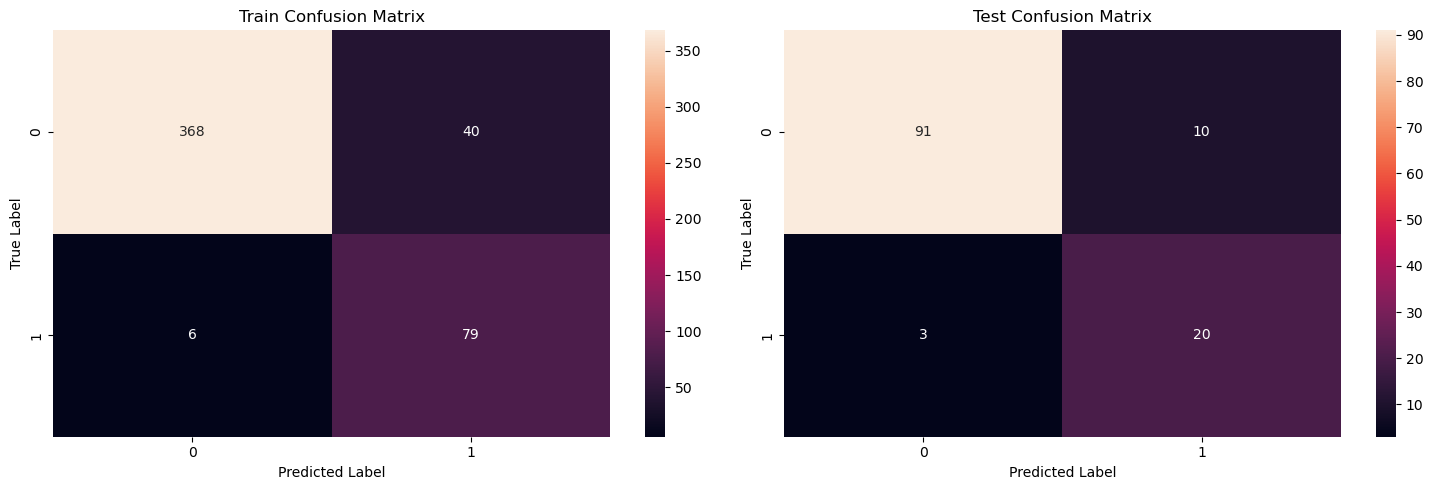

In [13]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, lg)

In [14]:
classification_report_df(lg)

Train Classification Report
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       408
           1       0.66      0.93      0.77        85

    accuracy                           0.91       493
   macro avg       0.82      0.92      0.86       493
weighted avg       0.93      0.91      0.91       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       101
           1       0.67      0.87      0.75        23

    accuracy                           0.90       124
   macro avg       0.82      0.89      0.84       124
weighted avg       0.91      0.90      0.90       124



- let's try to tune some hyperparameters to see if we can get better results.

In [15]:
# create the LogisticRegression object, giving the class_weight parameter
grid_lg = LogisticRegression(class_weight="balanced", n_jobs=-1)

distribs = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "max_iter": [5500],
    "solver": ["saga", "lbfgs"],
}

# train the model
best_params, grid_lg = grid_search(
    train_X, train_Y, grid_lg, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters:  {'C': 0.01, 'max_iter': 5500, 'penalty': 'l2', 'solver': 'saga'}
Train Balanced Logarithmic Loss:  0.36955227996417195
Test Balanced Logarithmic Loss:  0.39606058500178426


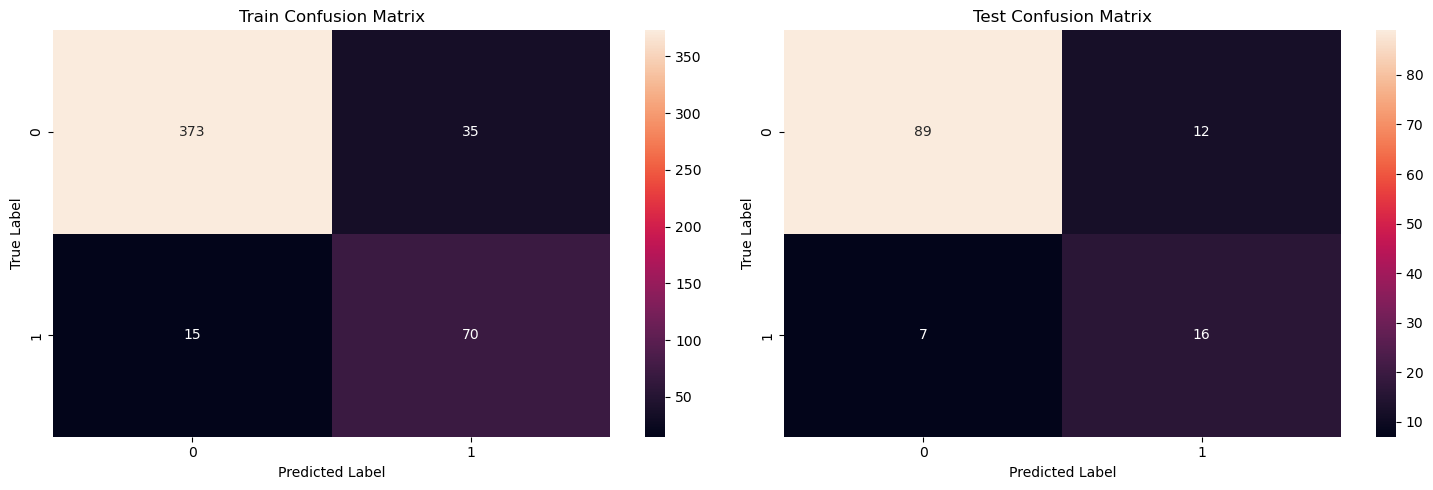

In [16]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_lg)

In [17]:
classification_report_df(grid_lg)

Train Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       408
           1       0.67      0.82      0.74        85

    accuracy                           0.90       493
   macro avg       0.81      0.87      0.84       493
weighted avg       0.91      0.90      0.90       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       101
           1       0.57      0.70      0.63        23

    accuracy                           0.85       124
   macro avg       0.75      0.79      0.77       124
weighted avg       0.86      0.85      0.85       124



- Let's try to narrow down the search

In [18]:
# create the LogisticRegression object, giving the class_weight parameter
grid_lg = LogisticRegression(class_weight="balanced", n_jobs=-1)

distribs = {
    "penalty": ["l2"],
    "C": [0.008, 0.01, 0.04],
    "max_iter": [5500, 6500],
    "solver": ["saga"],
}

# train the model
best_params, grid_lg = grid_search(
    train_X, train_Y, grid_lg, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:  {'C': 0.008, 'max_iter': 6500, 'penalty': 'l2', 'solver': 'saga'}
Train Balanced Logarithmic Loss:  0.367146445375496
Test Balanced Logarithmic Loss:  0.3953233623707161


- As there is no more improvement, So trying the another model

# SVM

## Kernel `rbf`

In [19]:
svm_rbf = SVC(kernel="rbf", class_weight="balanced", probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_rbf)

Train Balanced Logarithmic Loss:  0.34214127959010265
Test Balanced Logarithmic Loss:  0.48488482552889917


### Kernel `linear`

In [20]:
svm_linear = SVC(kernel="linear", class_weight="balanced", probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_linear)

Train Balanced Logarithmic Loss:  0.6255317401443156
Test Balanced Logarithmic Loss:  0.6442763795491988


- `linear` kernel is performing worse than `rbf` kernel.

### Kernel `poly`

In [21]:
svm_poly = SVC(kernel="poly", class_weight="balanced", probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_poly)

Train Balanced Logarithmic Loss:  0.6660617876139721
Test Balanced Logarithmic Loss:  0.7842499857660301


- more worst than `linear` kernel.

- So we will do a hyperparameter tuning for `rbf` kernel. 

In [22]:
grid_svm = SVC(class_weight="balanced", probability=True)

distribs = {
    "kernel": ["rbf"],
    "C": [0.001, 0.01, 0.1, 1],
    "gamma": ["scale", "auto"],
    "shrinking": [True, False],
}

# train the model
best_params, grid_svm = grid_search(
    train_X, train_Y, grid_svm, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
Train Balanced Logarithmic Loss:  0.34362930890117815
Test Balanced Logarithmic Loss:  0.48338294246281366


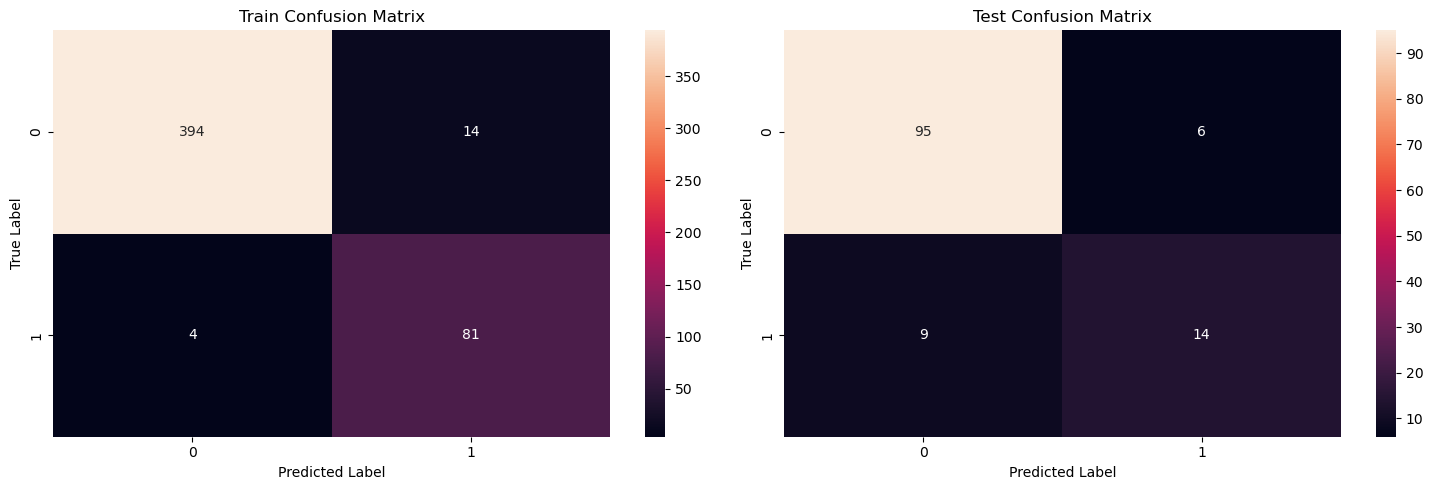

In [23]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_svm)

In [24]:
classification_report_df(grid_svm)

Train Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       408
           1       0.85      0.95      0.90        85

    accuracy                           0.96       493
   macro avg       0.92      0.96      0.94       493
weighted avg       0.97      0.96      0.96       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       101
           1       0.70      0.61      0.65        23

    accuracy                           0.88       124
   macro avg       0.81      0.77      0.79       124
weighted avg       0.87      0.88      0.88       124



- let's try to find the best hyperparameters for `rbf` kernel.

In [25]:
grid_svm2 = SVC(class_weight="balanced", probability=True)

distribs = {
    "kernel": ["rbf"],
    "C": [0.8, 0.9, 1],
    "gamma": ["auto"],
    "shrinking": [False],
}

# train the model
best_params, grid_svm2 = grid_search(
    train_X, train_Y, grid_svm2, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters:  {'C': 0.8, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': False}
Train Balanced Logarithmic Loss:  0.3527818640328134
Test Balanced Logarithmic Loss:  0.48972638534004354


- Almost same results as before. So we will stop here. and consider the previous result

# Decision Tree

In [26]:
# import the DecisionTreeClassifier class
from sklearn.tree import DecisionTreeClassifier

# create the DecisionTreeClassifier object, giving the class_weight parameter
dt = DecisionTreeClassifier(class_weight="balanced")

# train the model
train_model(train_X, train_Y, test_X, test_Y, dt)

Train Balanced Logarithmic Loss:  2.398525097706579
Test Balanced Logarithmic Loss:  7.079729740930597


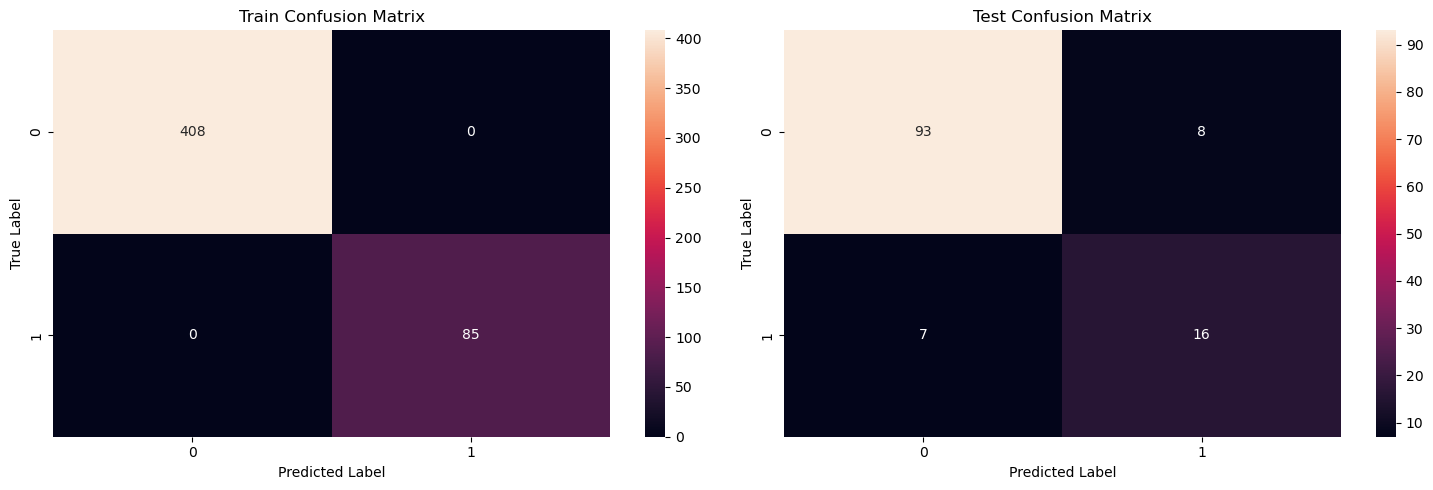

In [27]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, dt)

- It is clearlly overfitting.

In [28]:
grid_dt1 = DecisionTreeClassifier(class_weight="balanced")

distribs = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None, 2, 6, 7, 10],
    "min_samples_split": [2, 6, 10],
    "min_samples_leaf": [1, 6, 10],
    "max_features": ["sqrt", "log2"],
}

# train the model
best_params1, grid_dt1 = grid_search(
    train_X, train_Y, grid_dt1, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'random'}
Train Balanced Logarithmic Loss:  0.43069743798311994
Test Balanced Logarithmic Loss:  0.44324716803143466


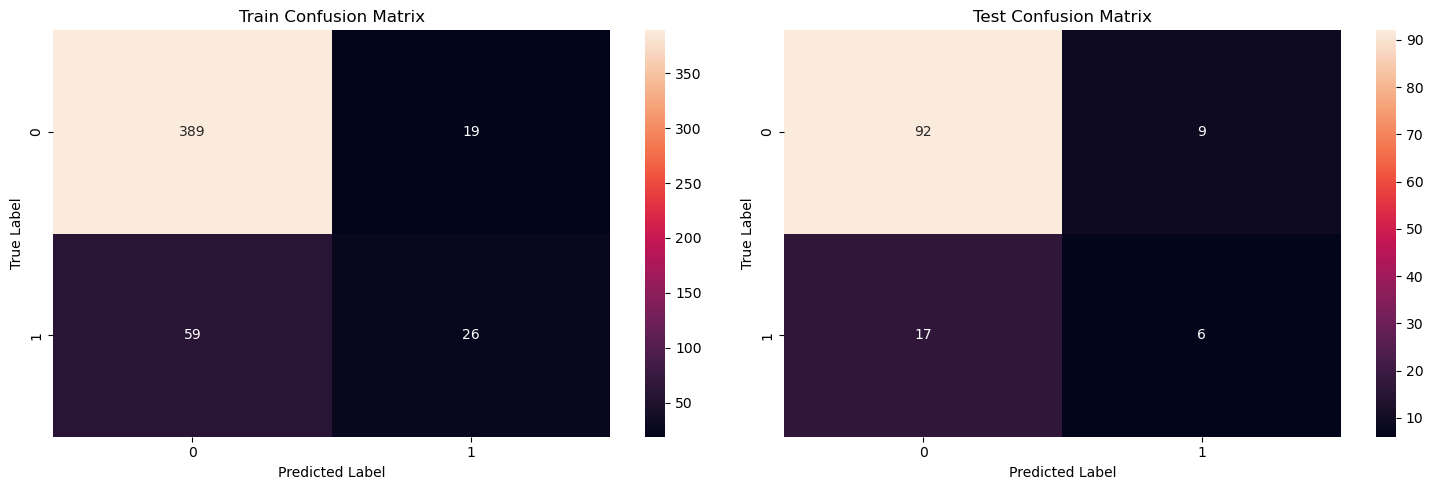

In [29]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_dt1)

In [30]:
classification_report_df(grid_dt1)

Train Classification Report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       408
           1       0.58      0.31      0.40        85

    accuracy                           0.84       493
   macro avg       0.72      0.63      0.65       493
weighted avg       0.82      0.84      0.82       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       101
           1       0.40      0.26      0.32        23

    accuracy                           0.79       124
   macro avg       0.62      0.59      0.60       124
weighted avg       0.76      0.79      0.77       124



- Now good still overfitting, So trying another model

# Random Forest

In [31]:
# create the RandomForestClassifier object, giving the class_weight parameter
rf = RandomForestClassifier(
    class_weight="balanced",
    max_depth=5,
    n_estimators=100,
    min_samples_split=4,
    min_samples_leaf=1,
)


# train the model
train_model(train_X, train_Y, test_X, test_Y, rf)

Train Balanced Logarithmic Loss:  0.3045245787181049
Test Balanced Logarithmic Loss:  0.40381801724243094


- This is performing better, let's do a Grid Search to hypertune

In [32]:
grid_rf = RandomForestClassifier(class_weight="balanced")

distribs = {
    "n_estimators": [100, 200, 300, 400, 500],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 7, 14],
    "min_samples_split": [2, 7, 14],
    "min_samples_leaf": [1, 7, 14],
}

# train the model
best_params, grid_rf = grid_search(
    train_X, train_Y, grid_rf, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 14, 'min_samples_split': 7, 'n_estimators': 200}
Train Balanced Logarithmic Loss:  0.30767483778833393
Test Balanced Logarithmic Loss:  0.35527951993908385


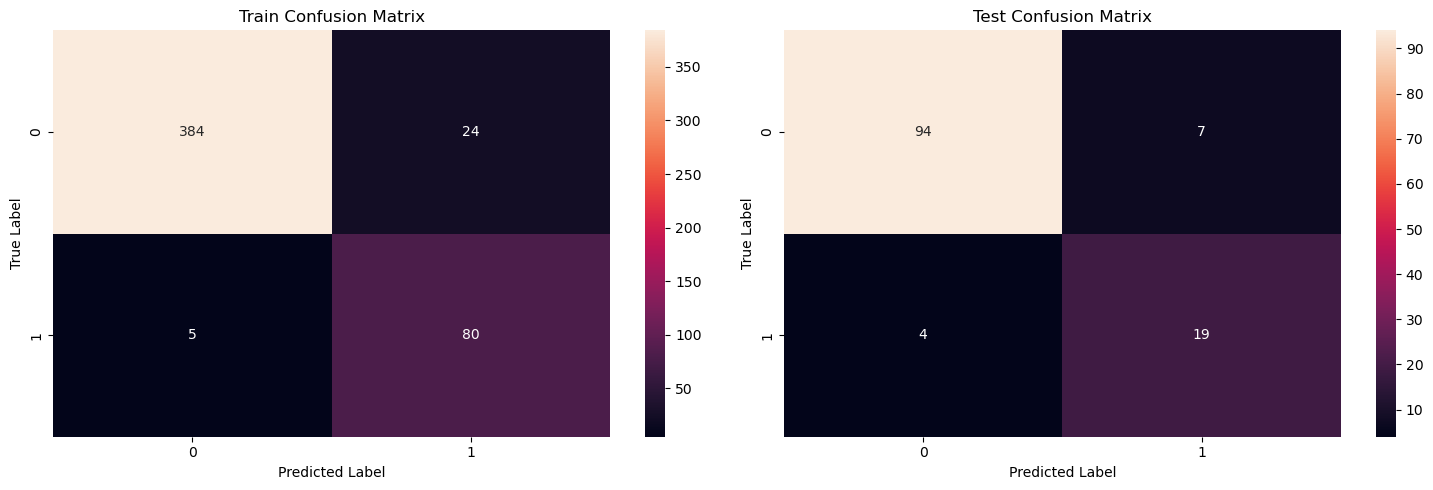

In [33]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_rf)

In [34]:
classification_report_df(grid_rf)

Train Classification Report
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       408
           1       0.77      0.94      0.85        85

    accuracy                           0.94       493
   macro avg       0.88      0.94      0.91       493
weighted avg       0.95      0.94      0.94       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       101
           1       0.73      0.83      0.78        23

    accuracy                           0.91       124
   macro avg       0.84      0.88      0.86       124
weighted avg       0.92      0.91      0.91       124



- Better results than before. Let's try to find the best hyperparameter in smaller range.

In [35]:
grid_rf2 = RandomForestClassifier(class_weight="balanced")

distribs = {
    "n_estimators": [100],
    "criterion": ["gini"],
    "max_depth": [13, 14, 16],
    "min_samples_split": [12, 14, 16],
    "min_samples_leaf": [13, 14, 15],
}

# train the model
best_params, grid_rf2 = grid_search(
    train_X, train_Y, grid_rf2, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters:  {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 15, 'min_samples_split': 12, 'n_estimators': 100}
Train Balanced Logarithmic Loss:  0.30808306085891213
Test Balanced Logarithmic Loss:  0.35149532917290865


- As the results are almost same hence, stop here.

# XGBoost

In [36]:
# create the XGBClassifier object, giving the class_weight parameter
xgb = XGBClassifier(
    scale_pos_weight=7,
    max_depth=3,
    n_estimators=4,
    min_child_weight=15,
)

# train the model
train_model(train_X, train_Y, test_X, test_Y, xgb)

Train Balanced Logarithmic Loss:  0.2973549237803501
Test Balanced Logarithmic Loss:  0.3184544741209344


- Let's tune the hyperparameters

In [37]:
grid_xgb = XGBClassifier(scale_pos_weight=7)

distribs = {
    "max_depth": [1, 2, 3, 5, 7],
    "n_estimators": [3, 4, 5, 6, 10, 15],
    "min_child_weight": [1, 7, 15],
    "gamma": [0.0, 0.1, 0.4],
    "subsample": [0.5, 0.8, 0.9],
    "colsample_bytree": [0.1, 0.5, 0.9],
    "learning_rate": [0.01, 0.05],
}

# train the model
best_params, grid_xgb = grid_search(
    train_X, train_Y, grid_xgb, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits
Best parameters:  {'colsample_bytree': 0.9, 'gamma': 0.4, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 15, 'n_estimators': 15, 'subsample': 0.8}
Train Balanced Logarithmic Loss:  0.3194817977208717
Test Balanced Logarithmic Loss:  0.34243380351796315


In [38]:
grid_xgb = XGBClassifier(scale_pos_weight=7)

distribs = {
    "max_depth": [3, 4],
    "n_estimators": [14, 15, 20],
    "min_child_weight": [14, 15, 16],
    "gamma": [0.3, 0.4, 0.5],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.8, 0.9, 0.99],
    "learning_rate": [0.05],
}

# train the model
best_params, grid_xgb = grid_search(
    train_X, train_Y, grid_xgb, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 15, 'n_estimators': 20, 'subsample': 0.7}
Train Balanced Logarithmic Loss:  0.30913961150628677
Test Balanced Logarithmic Loss:  0.33757504892025947


# CatBoost

In [39]:
# create the CatBoostClassifier object, giving the class_weight parameter
cat = CatBoostClassifier(class_weights=[1, 7], max_depth=3, n_estimators=40)

# train the model
train_model(train_X, train_Y, test_X, test_Y, cat)

Learning rate set to 0.145778
0:	learn: 0.6130920	total: 58.8ms	remaining: 2.29s
1:	learn: 0.5632829	total: 61.7ms	remaining: 1.17s
2:	learn: 0.5323438	total: 64.9ms	remaining: 801ms
3:	learn: 0.4867578	total: 67.1ms	remaining: 604ms
4:	learn: 0.4601126	total: 69.2ms	remaining: 484ms
5:	learn: 0.4375301	total: 71.2ms	remaining: 403ms
6:	learn: 0.4205904	total: 73.2ms	remaining: 345ms
7:	learn: 0.3964181	total: 75.2ms	remaining: 301ms
8:	learn: 0.3714688	total: 77.2ms	remaining: 266ms
9:	learn: 0.3536669	total: 79.1ms	remaining: 237ms
10:	learn: 0.3443909	total: 80.9ms	remaining: 213ms
11:	learn: 0.3256513	total: 82.8ms	remaining: 193ms
12:	learn: 0.3188621	total: 84.7ms	remaining: 176ms
13:	learn: 0.3105681	total: 86.7ms	remaining: 161ms
14:	learn: 0.3019806	total: 88.7ms	remaining: 148ms
15:	learn: 0.2949195	total: 90.7ms	remaining: 136ms
16:	learn: 0.2812659	total: 92.6ms	remaining: 125ms
17:	learn: 0.2692897	total: 94.5ms	remaining: 116ms
18:	learn: 0.2616267	total: 96.4ms	remaining

In [40]:
grid_cat = CatBoostClassifier(class_weights=[1, 7])

distribs = {
    "max_depth": [3, 4, 5],
    "n_estimators": [40, 50, 60],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
}

# train the model
best_params, grid_cat = grid_search(
    train_X, train_Y, grid_cat, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0:	learn: 0.6893326	total: 50.6ms	remaining: 1.97s
1:	learn: 0.6864423	total: 52.6ms	remaining: 999ms
2:	learn: 0.6823536	total: 60ms	remaining: 739ms
3:	learn: 0.6785401	total: 71.6ms	remaining: 645ms
4:	learn: 0.6745103	total: 100ms	remaining: 700ms
5:	learn: 0.6719089	total: 120ms	remaining: 679ms
6:	learn: 0.6666715	total: 139ms	remaining: 655ms
7:	learn: 0.6626649	total: 155ms	remaining: 618ms
8:	learn: 0.6592143	total: 180ms	remaining: 621ms
9:	learn: 0.6540406	total: 208ms	remaining: 624ms
10:	learn: 0.6494734	total: 221ms	remaining: 583ms
11:	learn: 0.6447526	total: 241ms	remaining: 561ms
12:	learn: 0.6421399	total: 254ms	remaining: 529ms
13:	learn: 0.6368160	total: 275ms	remaining: 511ms
14:	learn: 0.6319997	total: 305ms	remaining: 508ms
15:	learn: 0.6296916	total: 330ms	remaining: 495ms
16:	learn: 0.6262103	total: 343ms	remaining: 464ms
17:	learn: 0.6237304	total: 370ms	remaining: 453ms
18:	learn: 0.6190276	total: 

## Let's try to make the Ensemble

# VotingClassifier

- Weights to each model will be given according to their performance on the test data.

In [41]:
# create the EnsembleVoteClassifier object, giving the class_weight parameter

lg = LogisticRegression(class_weight="balanced", C= 0.008, max_iter= 5500, penalty= 'l2', solver= 'saga')


dtc = DecisionTreeClassifier(
    class_weight="balanced",
    criterion="gini",
    max_depth=2,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=6,
    splitter="best",
)


rf = RandomForestClassifier(
    class_weight="balanced",
    criterion="gini",
    max_depth=13,
    min_samples_leaf=15,
    min_samples_split=14,
    n_estimators=100,
)
    
xgb = XGBClassifier(
    scale_pos_weight=7,
    max_depth=3,
    n_estimators=4,
    min_child_weight=15,
)

cat = CatBoostClassifier(
    class_weights=[1, 7],
    l2_leaf_reg=5,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=40,
)


vc = VotingClassifier(
    estimators=[
        ("xgb", xgb),
        ("cat", cat),
        ("rf", rf),
        ("lg", lg),
        ("dtc", dtc),
    ],
    voting="soft",
    weights=[2, 2, 1.5, 1, 0.7],
)

# train the model
train_model(train_X, train_Y, test_X, test_Y, vc)

0:	learn: 0.6641547	total: 3.38ms	remaining: 132ms
1:	learn: 0.6422063	total: 5.89ms	remaining: 112ms
2:	learn: 0.6286917	total: 7.95ms	remaining: 98ms
3:	learn: 0.6000091	total: 9.91ms	remaining: 89.2ms
4:	learn: 0.5832639	total: 11.9ms	remaining: 83.4ms
5:	learn: 0.5676908	total: 13.8ms	remaining: 78.1ms
6:	learn: 0.5511523	total: 15.7ms	remaining: 74ms
7:	learn: 0.5356240	total: 17.7ms	remaining: 70.8ms
8:	learn: 0.5200837	total: 19.9ms	remaining: 68.5ms
9:	learn: 0.5096352	total: 22ms	remaining: 66ms
10:	learn: 0.4996982	total: 24ms	remaining: 63.2ms
11:	learn: 0.4839717	total: 26.2ms	remaining: 61.2ms
12:	learn: 0.4771642	total: 28.5ms	remaining: 59.2ms
13:	learn: 0.4710310	total: 30.8ms	remaining: 57.2ms
14:	learn: 0.4642302	total: 33ms	remaining: 54.9ms
15:	learn: 0.4574501	total: 35.3ms	remaining: 52.9ms
16:	learn: 0.4472159	total: 37.3ms	remaining: 50.5ms
17:	learn: 0.4356511	total: 39.7ms	remaining: 48.5ms
18:	learn: 0.4253477	total: 42ms	remaining: 46.4ms
19:	learn: 0.409289

# Final Model

In [42]:
# Training the VC on whole dataset and predicting on test dataset
vc_final = VotingClassifier(
    estimators=[
        ("xgb", xgb),
        ("cat", cat),
        ("rf", rf),
        ("lg", lg),
        ("dtc", dtc),
    ],
    voting="soft",
    weights=[2, 2, 1.5, 1, 0.7],
)
vc_final.fit(train_data, y_train)

0:	learn: 0.6690016	total: 3.8ms	remaining: 148ms
1:	learn: 0.6377905	total: 6.33ms	remaining: 120ms
2:	learn: 0.6204358	total: 8.34ms	remaining: 103ms
3:	learn: 0.5928077	total: 10.5ms	remaining: 94.2ms
4:	learn: 0.5724217	total: 12.7ms	remaining: 89ms
5:	learn: 0.5495528	total: 14.9ms	remaining: 84.6ms
6:	learn: 0.5311757	total: 17ms	remaining: 80.3ms
7:	learn: 0.5190387	total: 19.2ms	remaining: 76.7ms
8:	learn: 0.5047388	total: 21.4ms	remaining: 73.6ms
9:	learn: 0.4940539	total: 23.7ms	remaining: 71.2ms
10:	learn: 0.4849345	total: 26ms	remaining: 68.4ms
11:	learn: 0.4675606	total: 28.3ms	remaining: 66.1ms
12:	learn: 0.4592369	total: 30.6ms	remaining: 63.5ms
13:	learn: 0.4540186	total: 32.8ms	remaining: 60.9ms
14:	learn: 0.4489314	total: 35ms	remaining: 58.4ms
15:	learn: 0.4433169	total: 37.3ms	remaining: 56ms
16:	learn: 0.4345159	total: 39.7ms	remaining: 53.8ms
17:	learn: 0.4257606	total: 42ms	remaining: 51.3ms
18:	learn: 0.4154182	total: 44.3ms	remaining: 49ms
19:	learn: 0.4037771	

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                              <catboost.core.CatBoostClassifier object at 0x7d9c548ce1a0>),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=13,
                                                     min_samples_leaf=15,
                                                     min_samples_split=14)),
                             ('lg',
                              LogisticRegression(C=0.008,
                                                 class_weight='balanced',
                                                 max_iter=5500,
                                                 solver='saga')),
                             ('dtc',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=2,
                                                     max_features='sqrt',
                                                     min_samples_split=6))],
                 voting='soft', weights=[2, 2, 1.5, 1, 0.7])

# Predictions

In [43]:
# Predicting on test dataset
y_pred = vc_final.predict_proba(test_data)

In [44]:
submission = pd.DataFrame({'Id': ids, 'class_0': y_pred[:, 0], 'class_1': y_pred[:, 1]})

In [45]:
submission.to_csv('submission.csv', index=False)